# Random Forest classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-v0_8-colorblind')
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from src.utils.ds_formatter import format_all
from src.dataset import *
OLD_F_METADATA = "./data/HT_Sensor_metadata.dat"
F_METADATA = "./data/HT_Sensor_metadata_new.dat"
OLD_F_DATASET = "./data/HT_Sensor_dataset.dat"
F_DATASET = "./data/HT_Sensor_dataset_new.dat"

FEATURES = [
  'R1', 'R1_mean', 'R1_median', 'R1_dev',
  'R2', 'R2_mean', 'R2_median', 'R2_dev',
  'R3', 'R3_mean', 'R3_median', 'R3_dev',
  'R4', 'R4_mean', 'R4_median', 'R4_dev',
  'R5', 'R5_mean', 'R5_median', 'R5_dev',
  'R6', 'R6_mean', 'R6_median', 'R6_dev',
  'R7', 'R7_mean', 'R7_median', 'R7_dev',
  'R8', 'R8_mean', 'R8_median', 'R8_dev',
  'Temp.', 'Temp._mean', 'Temp._median', 'Temp._dev',
  'Humidity', 'Hum_mean', 'Hum_median', 'Hum_dev'
]

In [2]:
df = get_dataset(build_dataset=False)
df.shape

(7032, 41)

In [3]:
X=df[FEATURES]
y=df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f'{X_train.shape} {y_train.shape} {X_test.shape} {y_test.shape}')

(4922, 40) (4922,) (2110, 40) (2110,)


In [4]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=10, bootstrap=True, verbose=1)

In [5]:
clf.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(n_estimators=10, verbose=1)

In [6]:
y_pred=clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [7]:
def print_metrics(y_test, y_pred):
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1-score:",metrics.f1_score(y_test, y_pred, average='weighted'))
    plt.rcParams['figure.dpi'] = 70
    cm = metrics.confusion_matrix(y_test, y_pred)
    cmdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    cmdisp.plot()
    plt.show()

Accuracy: 0.9990521327014218
F1-score: 0.9990521327014218


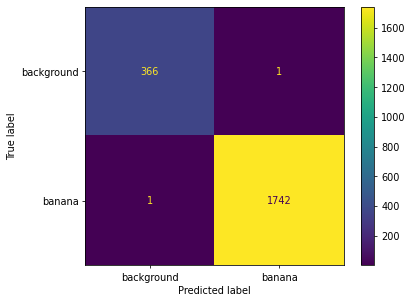

In [8]:
print_metrics(y_test, y_pred)

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=FEATURES).sort_values(ascending=False)
import seaborn as sns
fig, ax = plt.subplots(figsize=(24, 25))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, ax=ax)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Ahora probamos a entrenar el modelo con las features mas relevantes

In [11]:
FEATURES_2 = [
  'R1', 'R1_mean', 'R1_median', 'R1_dev',
  'R2', 'R2_mean', 'R2_median', 'R2_dev',
  'R3', 'R3_mean', 'R3_median', 'R3_dev',
  'R4', 'R4_mean', 'R4_median', 'R4_dev',
  'R5', 'R5_mean', 'R5_median', 'R5_dev',
  'R6', 'R6_mean', 'R6_median', 'R6_dev',
  'R7', 'R7_mean', 'R7_median', 'R7_dev',
  'R8', 'R8_mean', 'R8_median', 'R8_dev'
]
X=df[FEATURES_2]
y=df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f'{X_train.shape} {y_train.shape} {X_test.shape} {y_test.shape}')

(177589, 32) (177589,) (76110, 32) (76110,)


In [12]:
clf=RandomForestClassifier(n_estimators=10, bootstrap=True, verbose=1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy: 0.9999343056103008
F1-score: 0.9999343062530386


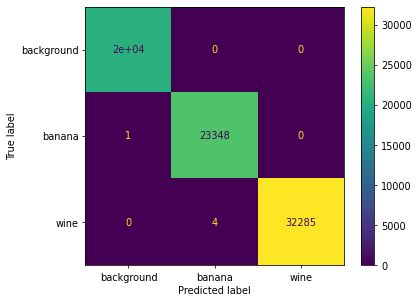

In [13]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F1-score:",metrics.f1_score(y_test, y_pred, average='weighted'))
plt.rcParams['figure.dpi'] = 70
cm = metrics.confusion_matrix(y_test, y_pred)
cmdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cmdisp.plot()
plt.show()

Como podemos ver, las métricas salen muy parecidas.

Ahora vamos a probar con K-Fold Cross-Validation:

In [15]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

FOLD nº0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 0.9999408750492708
Precision:	 0.9999408815270068
Recall:		 0.9999408750492708
F1-score:	 0.9999408746053884


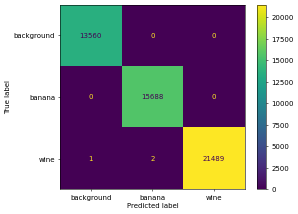

FOLD nº1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-score:	 1.0


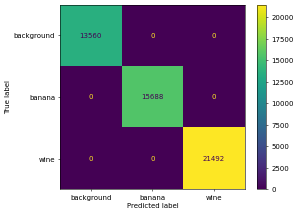

FOLD nº2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-score:	 1.0


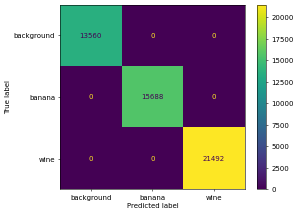

FOLD nº3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-score:	 1.0


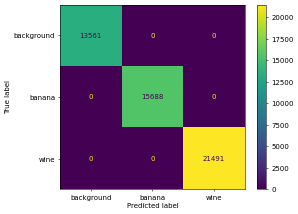

FOLD nº4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Accuracy:	 1.0
Precision:	 1.0
Recall:		 1.0
F1-score:	 1.0


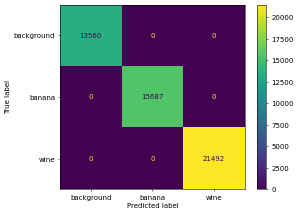

In [16]:
KFOLDS = 5
cv = StratifiedKFold(n_splits=KFOLDS, shuffle=True)

results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

X=df[FEATURES]
y=df['class']

for (train, test), i in zip(cv.split(X, y), range(KFOLDS)):
    print(f'FOLD nº{i}')
    X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy:\t",metrics.accuracy_score(y_test, y_pred))
    print("Precision:\t",metrics.precision_score(y_test, y_pred, average='weighted'))
    print("Recall:\t\t",metrics.recall_score(y_test, y_pred, average='weighted'))
    print("F1-score:\t",metrics.f1_score(y_test, y_pred, average='weighted'))
    plt.rcParams['figure.dpi'] = 50
    cm = metrics.confusion_matrix(y_test, y_pred)
    cmdisp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    cmdisp.plot()
    plt.show()

In [17]:
clf.predict([[12.8097,10.3655,10.4523,11.6734,13.4934,13.274,8.30527,9.04545,26.4241,59.4745,12.88422,12.8865,0.036958,10.424067,10.43245,0.02256,10.496109,10.50425,0.01669,11.723308,11.7306,0.019421,13.541656,13.5537,0.022596,13.373225,13.37765,0.040342,8.312446,8.313145,0.00318,9.055189,9.055575,0.005092,26.455474,26.45905,0.053763,58.969056,58.95435,0.255458]])

D:\workspace\FAA_proyecto\env\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


array(['banana'], dtype=object)

Probamos con una muestra creada de cero con datos de background

In [49]:
OLD_F_METADATA = "./data/HT_Sensor_metadata.dat"
F_METADATA = "./data/HT_Sensor_metadata_new.dat"
OLD_F_DATASET = "./data/HT_Sensor_dataset.dat"
F_DATASET = "./data/HT_Sensor_dataset_new.dat"
F_TEST_DATASET = "./data/filas_test.dat"

FEATURES_ORIGINAL = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']
FEATURES = [
  'R1', 'R1_mean', 'R1_median', 'R1_dev',
  'R2', 'R2_mean', 'R2_median', 'R2_dev',
  'R3', 'R3_mean', 'R3_median', 'R3_dev',
  'R4', 'R4_mean', 'R4_median', 'R4_dev',
  'R5', 'R5_mean', 'R5_median', 'R5_dev',
  'R6', 'R6_mean', 'R6_median', 'R6_dev',
  'R7', 'R7_mean', 'R7_median', 'R7_dev',
  'R8', 'R8_mean', 'R8_median', 'R8_dev',
  'Temp.', 'Temp._mean', 'Temp._median', 'Temp._dev',
  'Humidity', 'Hum_mean', 'Hum_median', 'Hum_dev'
]

time_window = 5
md = pd.read_csv(F_METADATA, sep=",")
d = pd.read_csv(F_DATASET, sep=",")
d.set_index(np.arange(d.shape[0]), inplace=True)

with open(F_TEST_DATASET, 'w') as f:
    # Headers
    f.write(','.join(FEATURES) + '\n')

    """
    1. Por cada serie (misma ID) en HT_Sensor_dataset_new.dat
      2. Calcular media, mediana y desv. de cada sensor, temperatura y humedad en base a los ultimos 5 minutos
      3. Añadir la nueva entrada a Final_dataset.dat
    """
    for i, md_row in md.iterrows():
        ide = md_row['id']
        if ide > 0:
            break
        clase = md_row['class']
        print(f'{ide} {clase} .... ', end='')

        for j, d_row in d.iterrows():
            # Si no son la misma serie, pasamos al siguiente
            if md_row['id'] != d_row['id']: continue

            # Ignorar la ventana
            if d_row['time'] >= 0 and d_row['time'] <= md_row['dt']: continue

            search_to = d_row['time']*60            # Muestra actual a minutos
            search_from = search_to - time_window   # Ventana de 5 minutos desde la que empezar a buscar

            # Debe estar dentro de la ventana de tiempo y tener el mismo ID.
            window = d[(d['time']*60 >= search_from) & (d['time']*60 < search_to) & (d['id'] == md_row['id'])]
            if window.empty: continue

            for f_o in FEATURES_ORIGINAL:
                # 1. Calcular medias, medianas y desviaciones de los atributos del df 'window'
                mean = window[f_o].mean()
                median = window[f_o].median()
                dev = window[f_o].std(ddof=0)
                d_row[f'{f_o}_mean'] = mean
                d_row[f'{f_o}_median'] = median
                d_row[f'{f_o}_dev'] = dev

            # 2. Esos nuevos valores obtenidos, meterlos a la entrada 'd_row' y guardarla: f.write(new_row)
            x = d_row[2:].to_string(index=False).split('\n')
            new_row = [','.join(ele.split()) for ele in x]
            f.write(','.join(new_row) + '\n')
            
        print('OK')

0 banana .... OK


In [50]:
dtest = pd.read_csv(F_TEST_DATASET, sep=",")
dtest['class']  = 'background'
dtest.head()

,R1,R1_mean,R1_median,R1_dev,R2,R2_mean,R2_median,R2_dev,R3,R3_mean,...,R8_dev,Temp.,Temp._mean,Temp._median,Temp._dev,Humidity,Hum_mean,Hum_median,Hum_dev,class
0,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299,...,8.739010,8.739010,0.000000,26.22570,26.22570,0.000000,59.052800,59.05280,0.000000,background
1,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093,...,8.739045,8.739045,0.000035,26.22825,26.22825,0.002550,59.041350,59.04135,0.011450,background
2,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905,...,8.739080,8.739080,0.000057,26.23100,26.23080,0.004411,59.030667,59.02990,0.017767,background
3,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736,...,8.739150,8.739115,0.000131,26.23365,26.23365,0.005972,59.020625,59.01960,0.023222,background
4,12.8594,10.3691,10.4376,11.6702,13.4921,13.3382,8.04088,8.74016,26.2503,58.9583,...,8.739292,8.739150,0.000307,26.23616,26.23650,0.007330,59.011220,59.00930,0.028022,background


(6972,) (6972, 40)
0    background
1    background
2    background
3    background
4    background
5    background
Name: class, dtype: object
['banana' 'banana' 'banana' 'banana' 'banana' 'banana']
Accuracy: 0.006597819850831899
F1-score: 0.013109147905386151


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


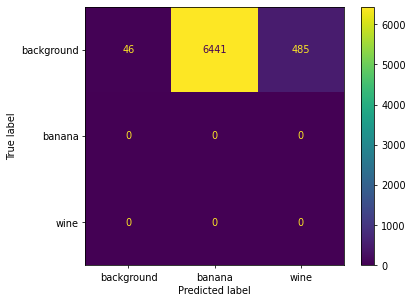

In [51]:
y_test=dtest['class']
X_test = dtest[FEATURES]
print(y_test.shape, X_test.shape)
y_pred = clf.predict(X_test)

print(y_test[:6])
print(y_pred[:6])

print_metrics(y_test, y_pred)